# Introduction to Data Science and Machine Learning

<p align="center">
    <img width="699" alt="image" src="https://user-images.githubusercontent.com/49638680/159042792-8510fbd1-c4ac-4a48-8320-bc6c1a49cdae.png">
</p>

---

## Time series Decomposition

In particular, over this notebook we are going to explore techniques to decompose time series into their fundamental components. We have already seen _seasonality_, we are going to better define _trend_, _level_ and _residuals_.
Furthermore, we are going to describe two ways of doing that

1. Additive model
2. Multiplicative model

### Import libraries and data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (25.0, 15.0)
sns.set()

In [2]:
url_data = "https://raw.githubusercontent.com/fbagattini/Lezioni/master/data/OPSD_Germany_all.csv"

### Trends
Let's start by picturing consumption data at a daily frequency.

In [3]:
df = pd.read_csv(url_data,
                 parse_dates=True,
                 index_col='Date')

df['Weekday'] = df.index.day_name()

df.head()

,Consumption,Wind,Solar,Weekday
Date,,,,
2006-01-01,1069.184,NaN,NaN,Sunday
2006-01-02,1380.521,NaN,NaN,Monday
2006-01-03,1442.533,NaN,NaN,Tuesday
2006-01-04,1457.217,NaN,NaN,Wednesday
2006-01-05,1477.131,NaN,NaN,Thursday


Let's also plot our data.

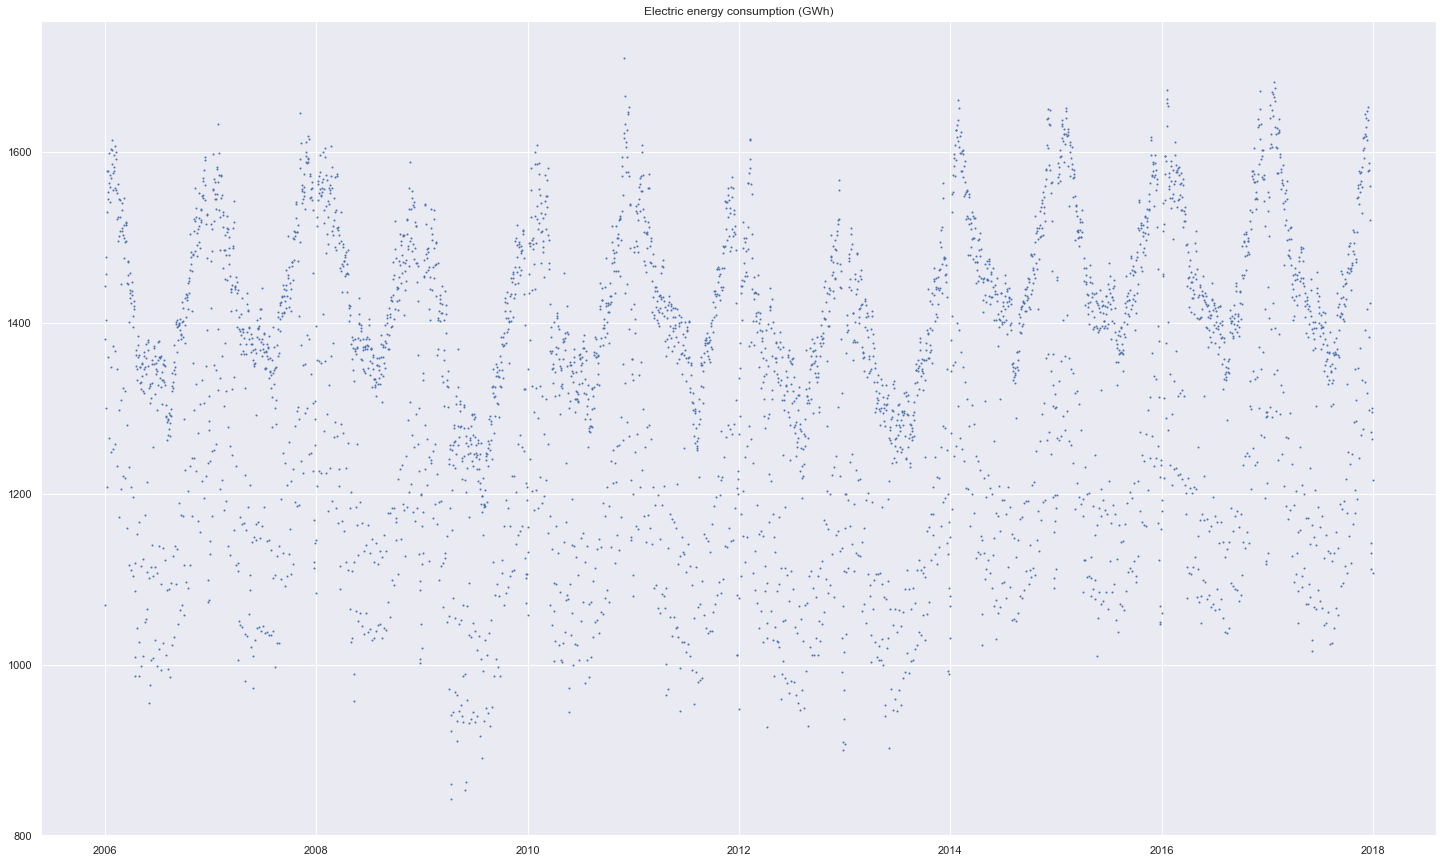

In [4]:
plt.plot(df['Consumption'],
         marker='.',
         markersize=2,
         linestyle='')
plt.title('Electric energy consumption (GWh)');

As one can see, here we have both weekly and yearly seasonality.
Let's get read of the weekly one by a rolling average over a week wide window.

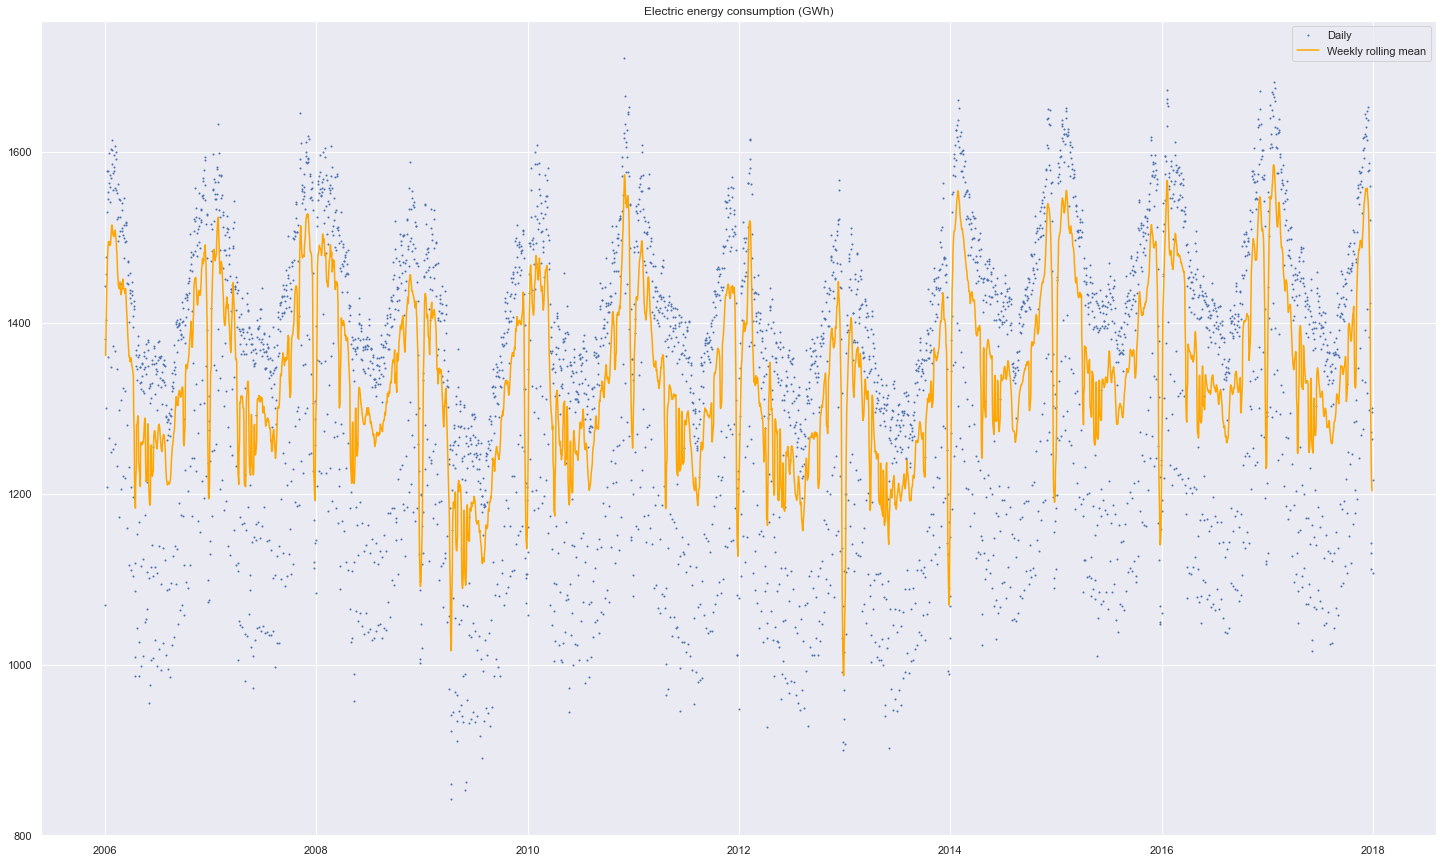

In [5]:
plt.plot(df['Consumption'],
         marker='.',
         markersize=2,
         linestyle='',
         label='Daily')

plt.plot(df['Consumption'].rolling(7, center=True).mean(),
         label='Weekly rolling mean',
         color='orange')

plt.title('Electric energy consumption (GWh)')
plt.legend();

As we expected, the weekly rolling mean cancels the corresponding seasonality. On the other hand _yearly seasonality_ is highlighted, and we can observe:
* the oscillating trend caused by electric heating and increased lighting usage
* negative peaks during winter holidays.

Let's continue the analysis by adding the yearly rolling mean to our plot.

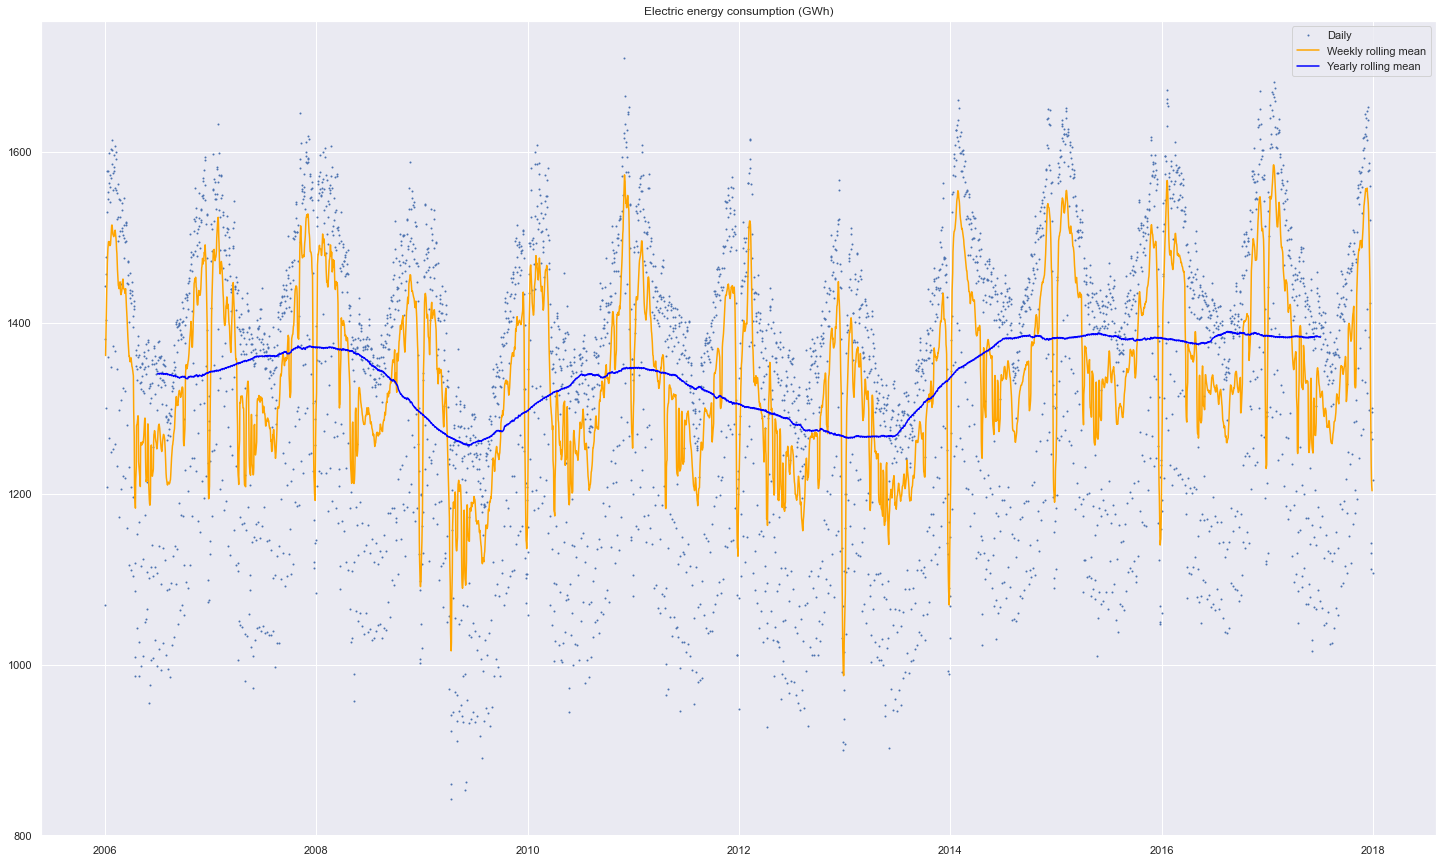

In [6]:
plt.plot(df['Consumption'],
         marker='.',
         markersize=2,
         linestyle='',
         label='Daily')

plt.plot(df['Consumption'].rolling(7, center=True).mean(),
         label='Weekly rolling mean',
         color='orange')

plt.plot(df['Consumption'].rolling(365, center=True).mean(),
         label='Yearly rolling mean',
         color='blue')

plt.title('Electric energy consumption (GWh)')
plt.legend();

Once we get rid of a time series' seasonality, what is left is its _long-term trend_.

Well, sort of: we will get back on this later on.

---

## Exercise 1

Analyse the trend in solar energy production starting from $2012$.

Compare, starting from $2006$, the trends in

* solar energy production
* wind energy production
* total production of renewable energy.

---

## Linear, quadratic and exponential trend

Before moving on, let's make a brief comparison between typical trends. We will generate them synthetically by using NumPy.

Let's start by the easy one: A _constant trend_ is a horizontal straight line: its rate of growth is zero.

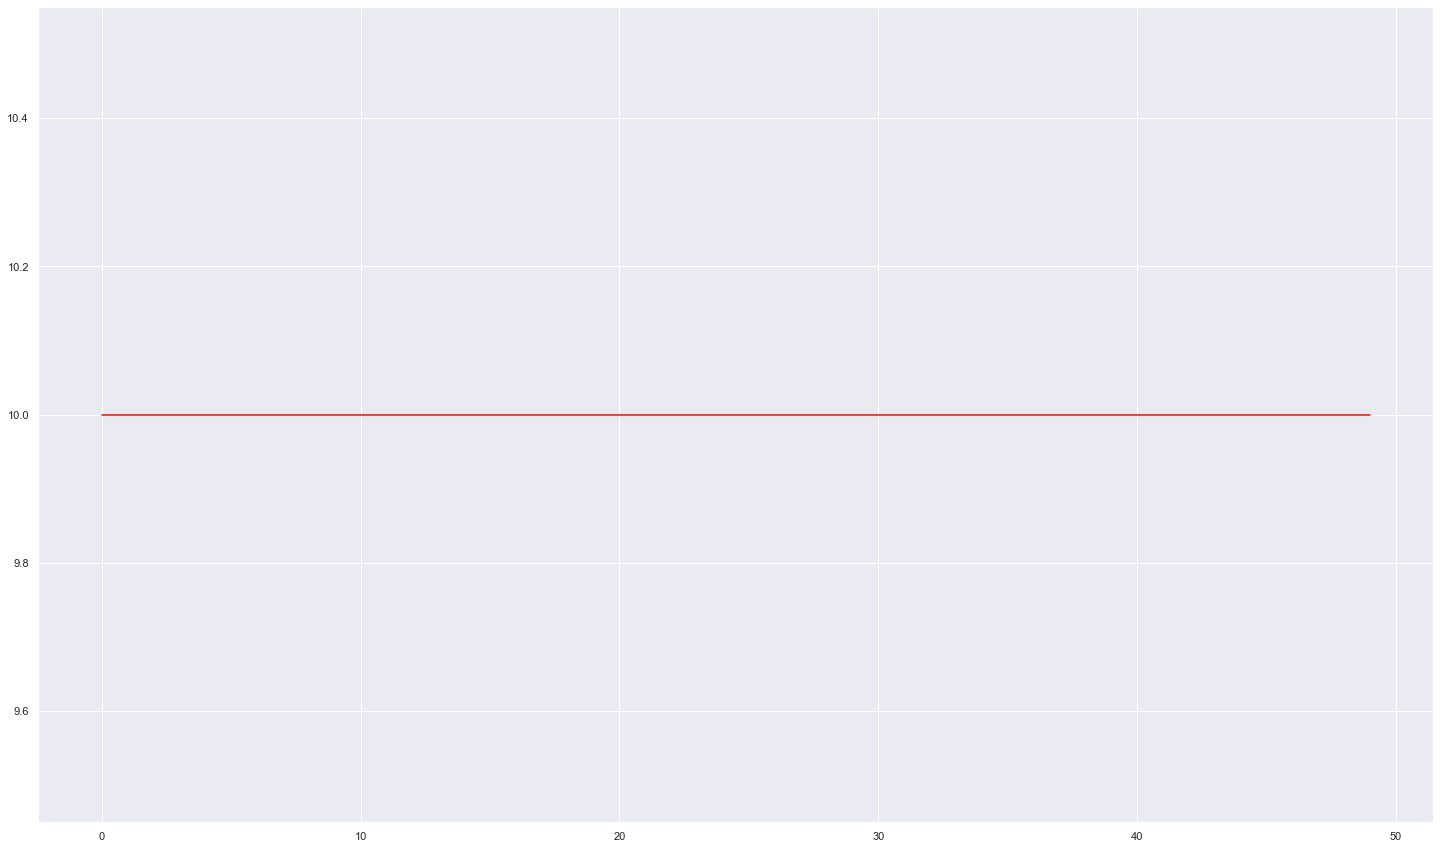

In [7]:
constant_trend = np.array([10 for t in range(50)])
plt.plot(constant_trend, color='red');

A linear trend is an sloping straight line: the rate of growth is different than zero, though it does not change over time.

In [8]:
linear_trend = np.array([5*t for t in range(50)])
linear_trend

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245])

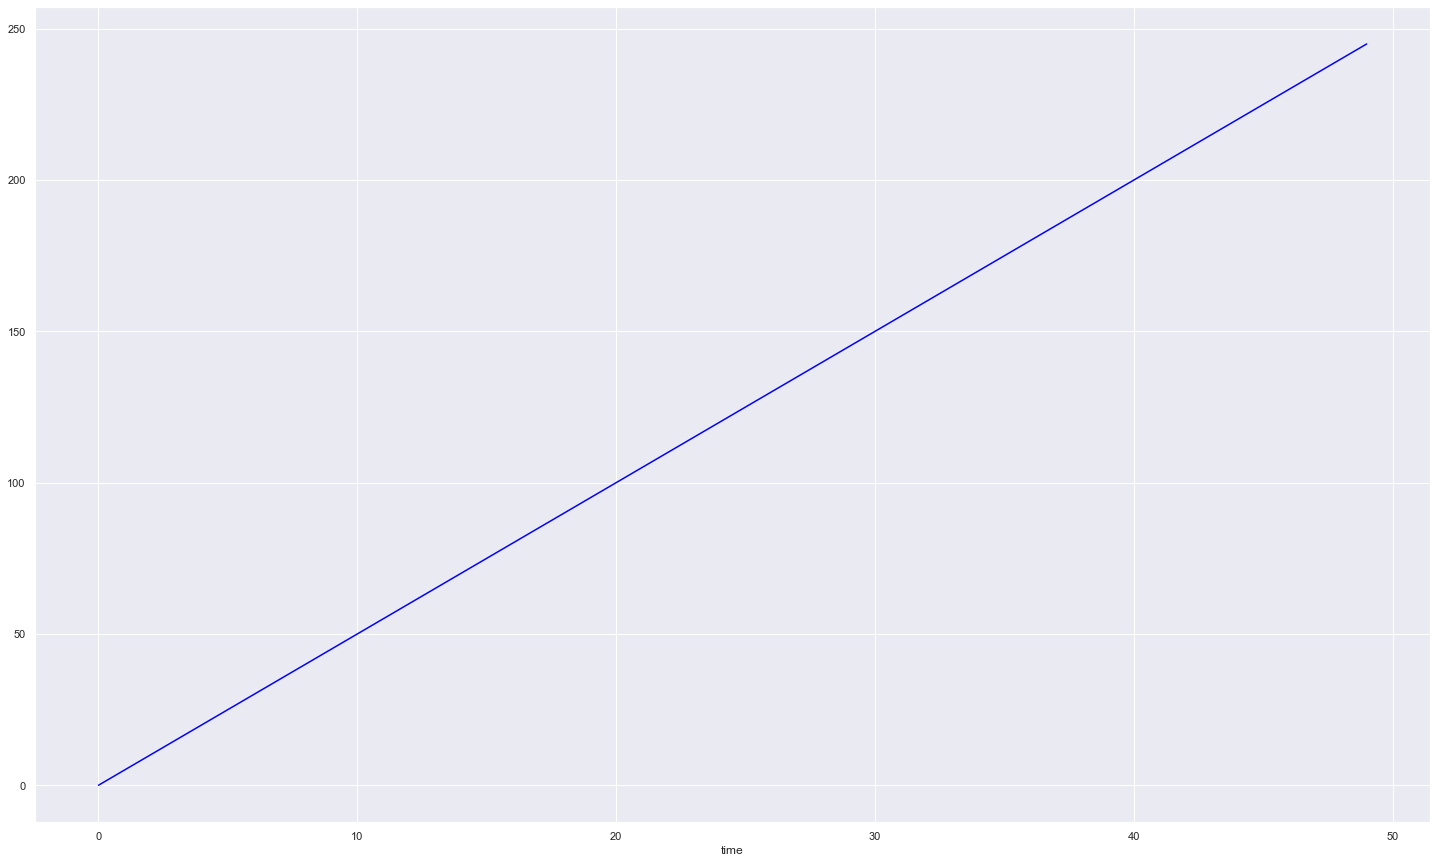

In [9]:
plt.xlabel('time')
plt.plot(linear_trend, color='blue');

A _quadratic trend_ (or more generally a _polynomial one_) can be compared with a curved line, and its rate of growth (_i.e._ its derivative) does change over time.

In [10]:
quadratic_trend = np.array([t**2 for t in range(50)])
quadratic_trend

array([   0,    1,    4,    9,   16,   25,   36,   49,   64,   81,  100,
        121,  144,  169,  196,  225,  256,  289,  324,  361,  400,  441,
        484,  529,  576,  625,  676,  729,  784,  841,  900,  961, 1024,
       1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849,
       1936, 2025, 2116, 2209, 2304, 2401])

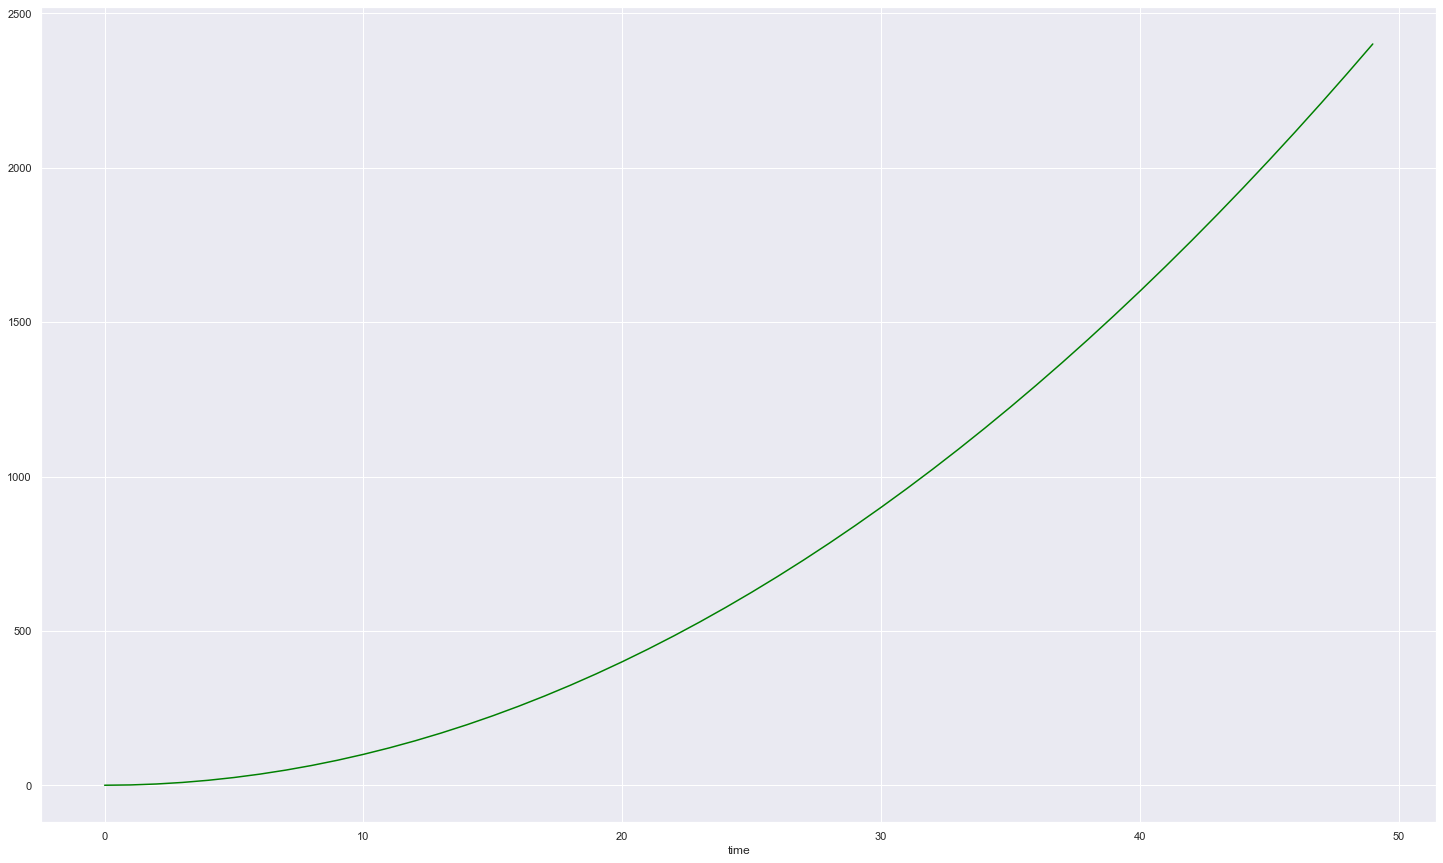

In [11]:
plt.xlabel('time')
plt.plot(quadratic_trend, color='green');

Let's plot, just for fun a $5$-th degree polynomial.

In [12]:
pol_trend = np.array([(1 + 37*t -53*t**2 + 21*t**3 -2.7*t**4 + (1/10)*t**5) for t in range(23)])

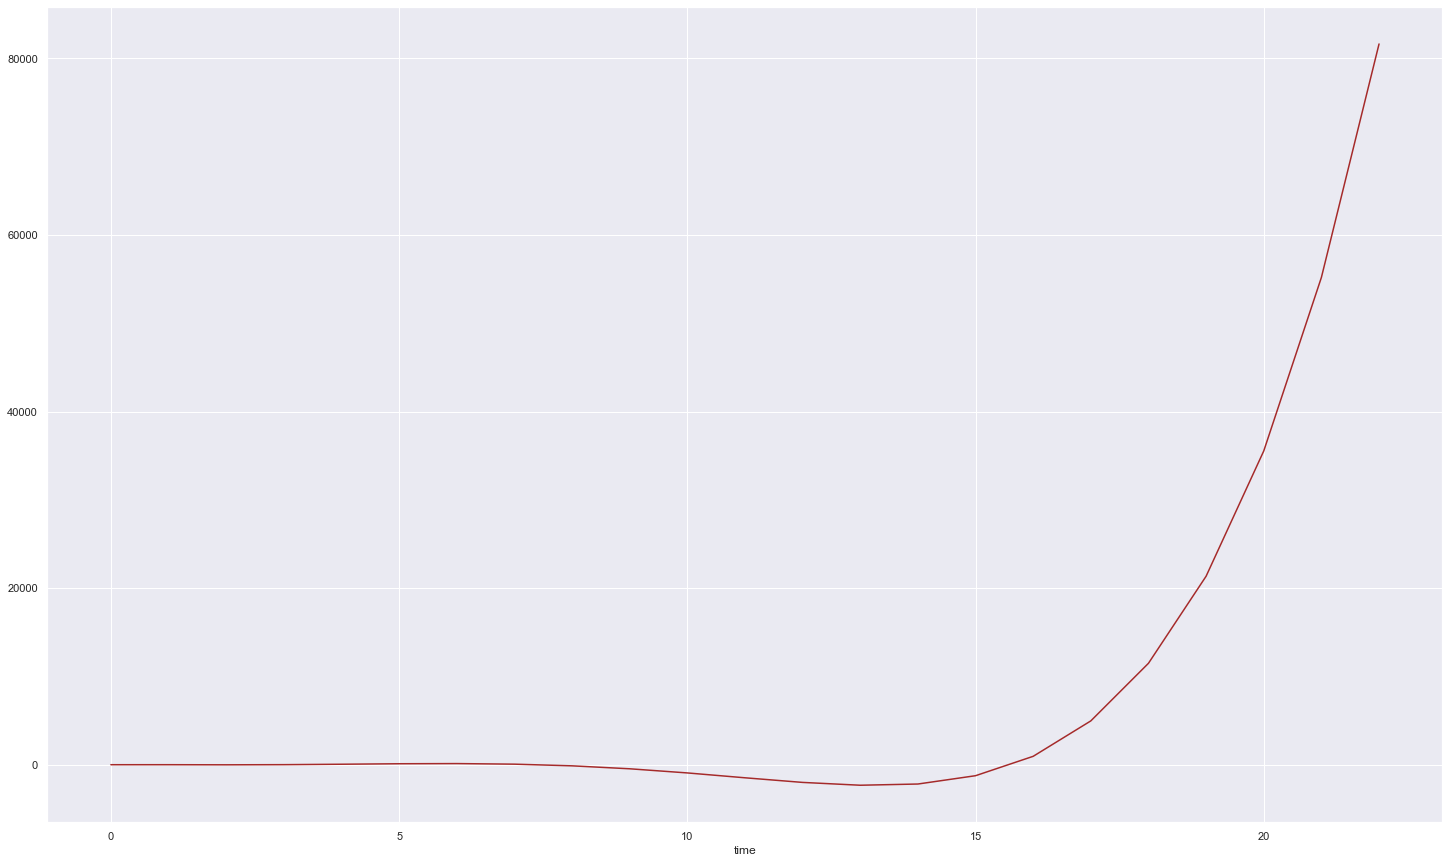

In [13]:
plt.xlabel('time')
plt.plot(pol_trend, color='brown');

As you can guess, an _exponential trend_ is a curved line too, but its rate of growth varies a lot faster: time is the exponent! (And its derivative too).

In [14]:
exponential_trend = np.array([2**t for t in range(50)])
exponential_trend

array([              1,               2,               4,               8,
                    16,              32,              64,             128,
                   256,             512,            1024,            2048,
                  4096,            8192,           16384,           32768,
                 65536,          131072,          262144,          524288,
               1048576,         2097152,         4194304,         8388608,
              16777216,        33554432,        67108864,       134217728,
             268435456,       536870912,      1073741824,      2147483648,
            4294967296,      8589934592,     17179869184,     34359738368,
           68719476736,    137438953472,    274877906944,    549755813888,
         1099511627776,   2199023255552,   4398046511104,   8796093022208,
        17592186044416,  35184372088832,  70368744177664, 140737488355328,
       281474976710656, 562949953421312])

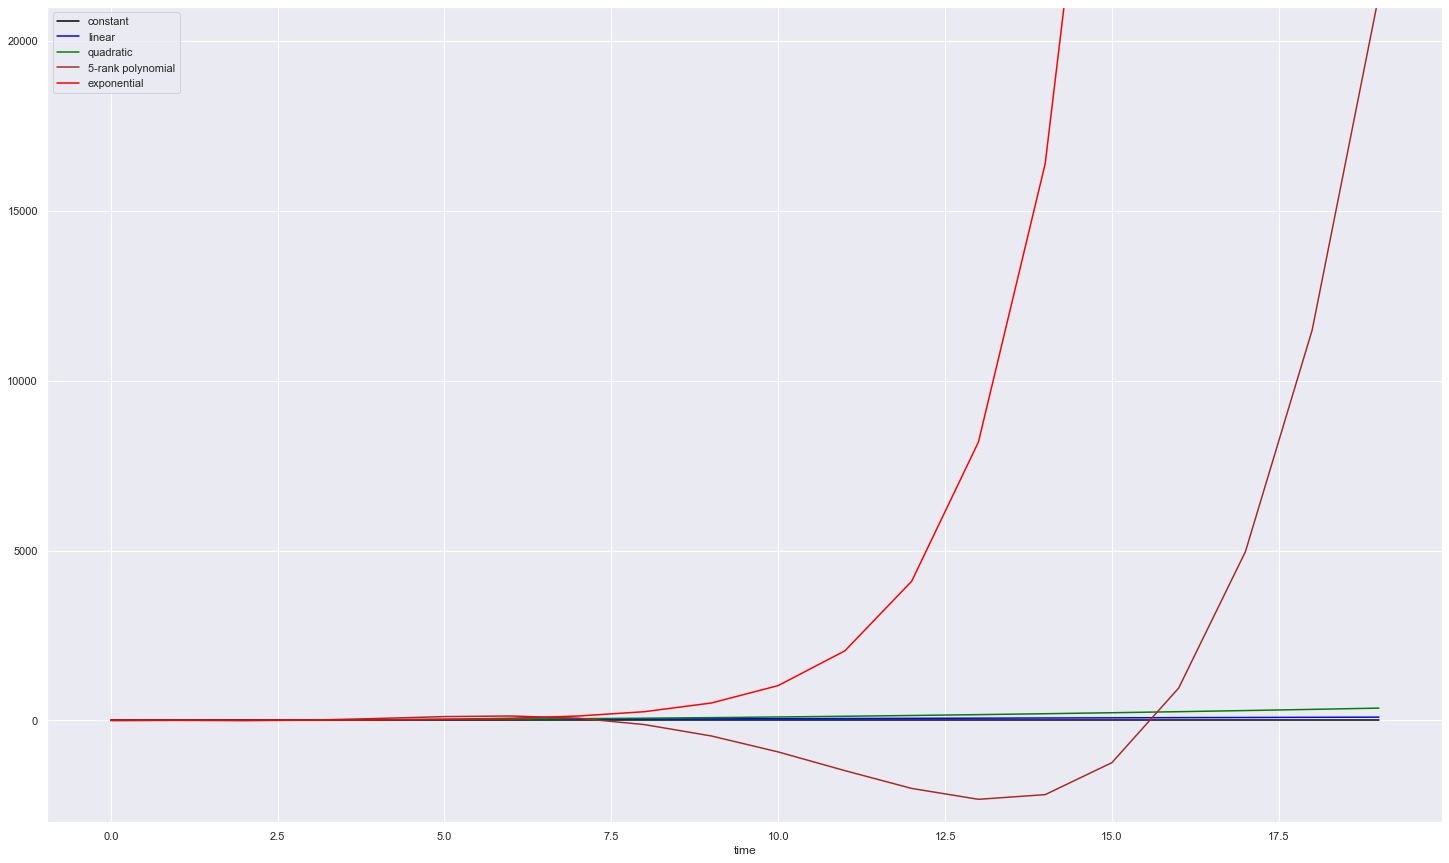

In [15]:
plt.plot(constant_trend[:20], label='constant', color='black')
plt.plot(linear_trend[:20], label='linear', color='blue')
plt.plot(quadratic_trend[:20], label='quadratic', color='green')
plt.plot(pol_trend[:20], label='5-rank polynomial', color ='brown')
plt.plot(exponential_trend[:20], label='exponential', color='red')

plt.ylim(bottom=-3000, top=21000) 
plt.xlabel('time')
plt.legend();

**Recap**: so far we have defined and analysed two of the main components of a time series, namely its seasonality and trend(s). We have also introduced some typical example of trend.

---

## Decomposition

After having analysed the kind of trends, let's continue with the concept of decomposition of a time series.
There are two _classical ways_ to decompose a time series, they depends on how we interpret the various components contribute to the time series modelling.

### Additive model

_Trend_ and _seasonality_ are structural, systematic components of a time series; that is, they can be analysed and modeled. Another systematic component of a series is the _level_: to put it simply, its average value. We can think of it as a flat (zero growth) linear trend.

Hence, in this view, a time series can be re-written as follows:

$$ x(t) = \lambda + \psi_s(t) + \psi_{\tau}(t) + \varepsilon(t) \, ,$$

where $\lambda$, $\psi_s$, $\psi_{\tau}$ and $\varepsilon$ are _level_, _seasonality_, _trend_ and _residuals_ respectively.

You can see why this is called __additive model__, as it modelise the time series as the sum of its terms. 
$\varepsilon$ is called residual: the non-systematic component which cannot be straight modeled.

> How we decompose a time series?

Let's see the additive model in some more detail.

Here we define the _seasonal characteristic period_ as $\mu$. For instance $\mu = 12$ for monthly data, $\mu = 7$ for weekly data and so on.

##### Step 1
We want to compute the trend-cycle component $\psi_{\tau}(t)$. If $\mu$ is an even number, we use a _moving average_ over $2\mu$-wide windows, otherwise through $\mu$-wide windows.

##### Step 2
Hence, we calculate the _detrended series_:  

$$y(t) - \psi_{\tau}(t)\, .$$

##### Step 3
To estimate the seasonal component for each season, simply average the detrended values for that season. For example, with monthly data, the seasonal component for March is the average of all the detrended March values in the data. These seasonal component values are then adjusted to ensure that they add to zero. The seasonal component is obtained by stringing together these monthly values, and then replicating the sequence for each year of data. This gives

$$\psi_s(t)\, .$$

##### Step 4
The remainder component is calculated by subtracting the estimated seasonal and trend-cycle components:

$$\varepsilon(t) = y(t) - \psi_{\tau}(t) - \psi_s(t)\, .$$

---
#### How to do that in real life.
Easy! There is a library!

`seasonal_decompose`

The `seasonal_decompose` function (statsmodel library) allows to decompose a series into its terms.

**Note**: this is a quite naive decomposition, you can find examples of more sophisticated ones [here](https://otexts.com/fpp2/decomposition.html).

In [16]:
decomposition = seasonal_decompose(df['Consumption']['2015-01':'2015-06'])

The variable `decomposition`, contains the result of the function, which is an object containing a Pandas series for each of the components.

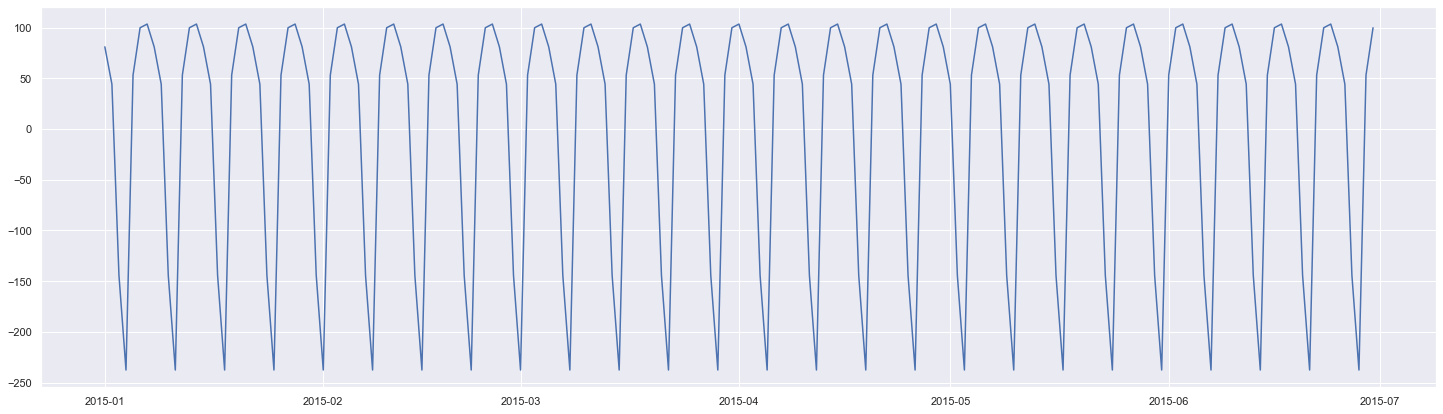

In [17]:
plt.figure(figsize=(25,7))
plt.plot(decomposition.seasonal);

We can also represent all the components in a single plot.

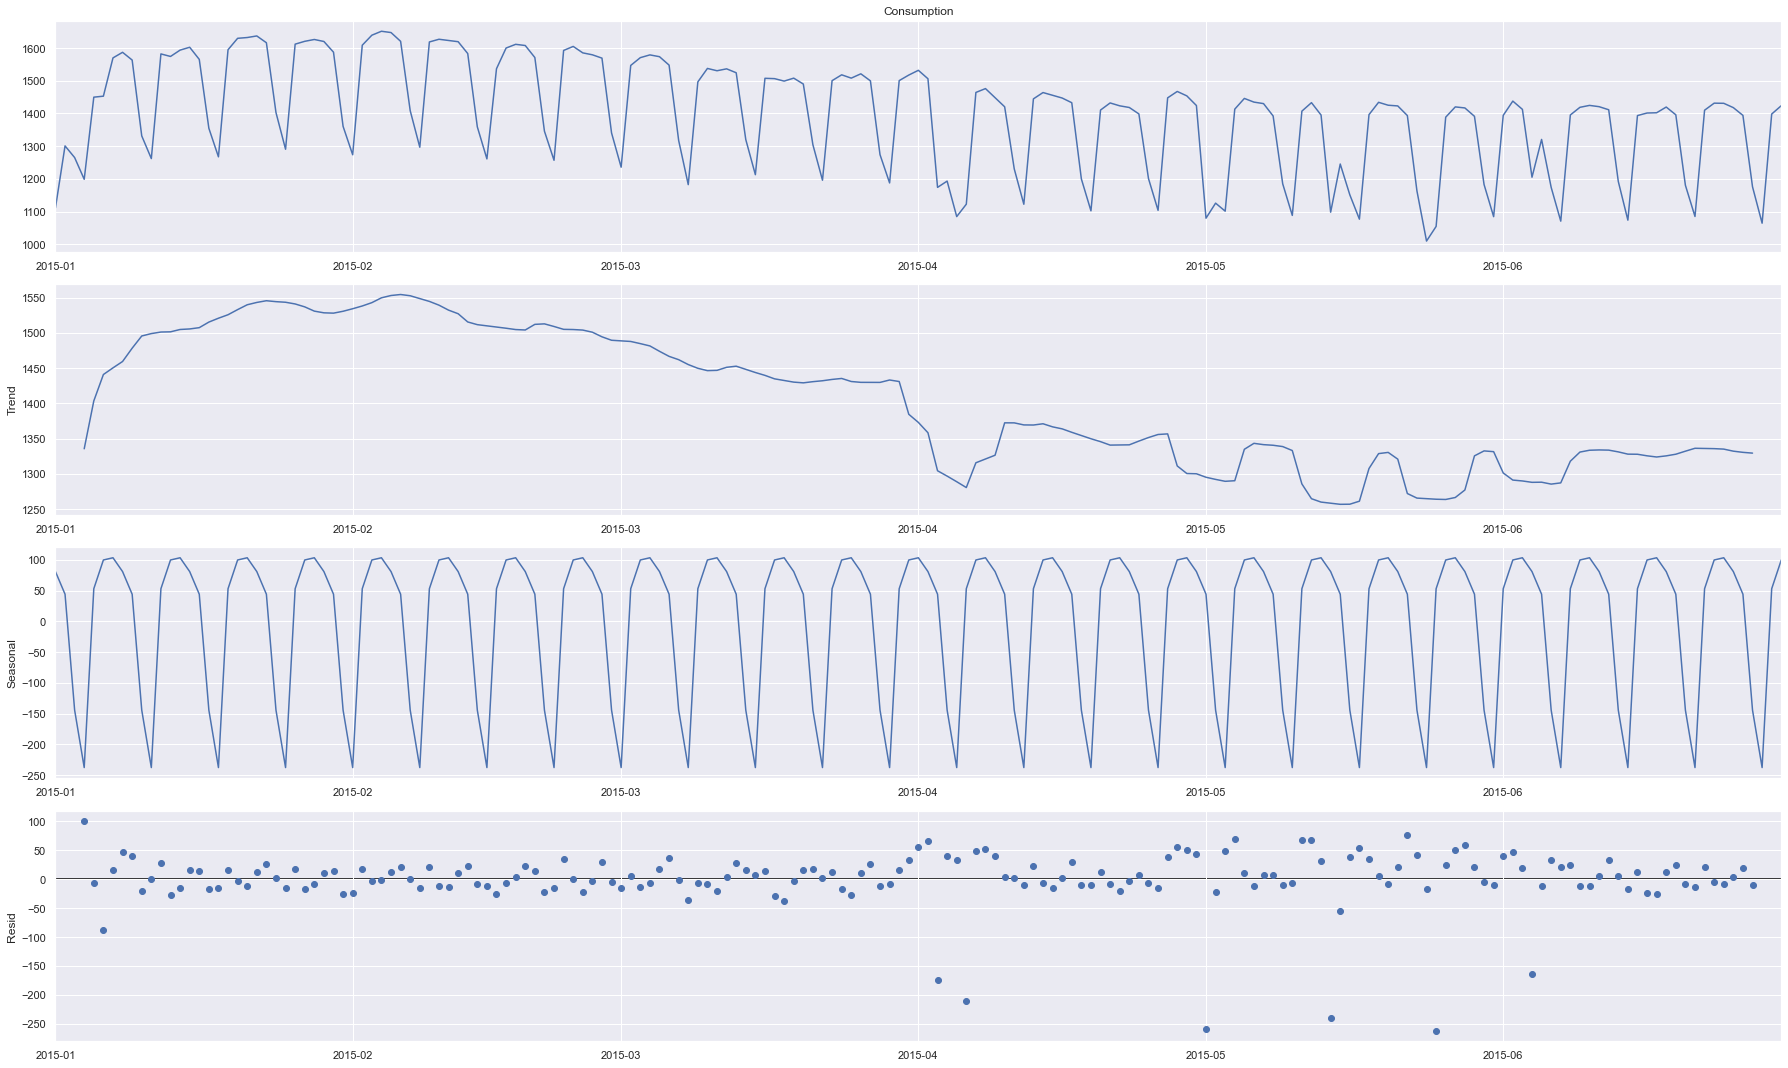

In [18]:
plot = decomposition.plot()#avoids repeated plots

### Multiplicative model

As you can say by its name, this modelling framework assumes the time series to be the _product_ of its terms:

$$ x(t) = \lambda \times \psi_s(t) \times \psi_{\tau}(t) \times \varepsilon(t) \, ,$$

where $\lambda$, $\psi_s$, $\psi_{\tau}$ and $\varepsilon$ are _level_, _seasonality_, _trend_ and _residuals_ respectively.

#### Details
A classical multiplicative decomposition is similar to the steps of the additive one, except that the subtractions are replaced by divisions. 😉

In [19]:
decomposition = seasonal_decompose(df['Consumption']['2015-01':'2015-06'], model='multiplicative')

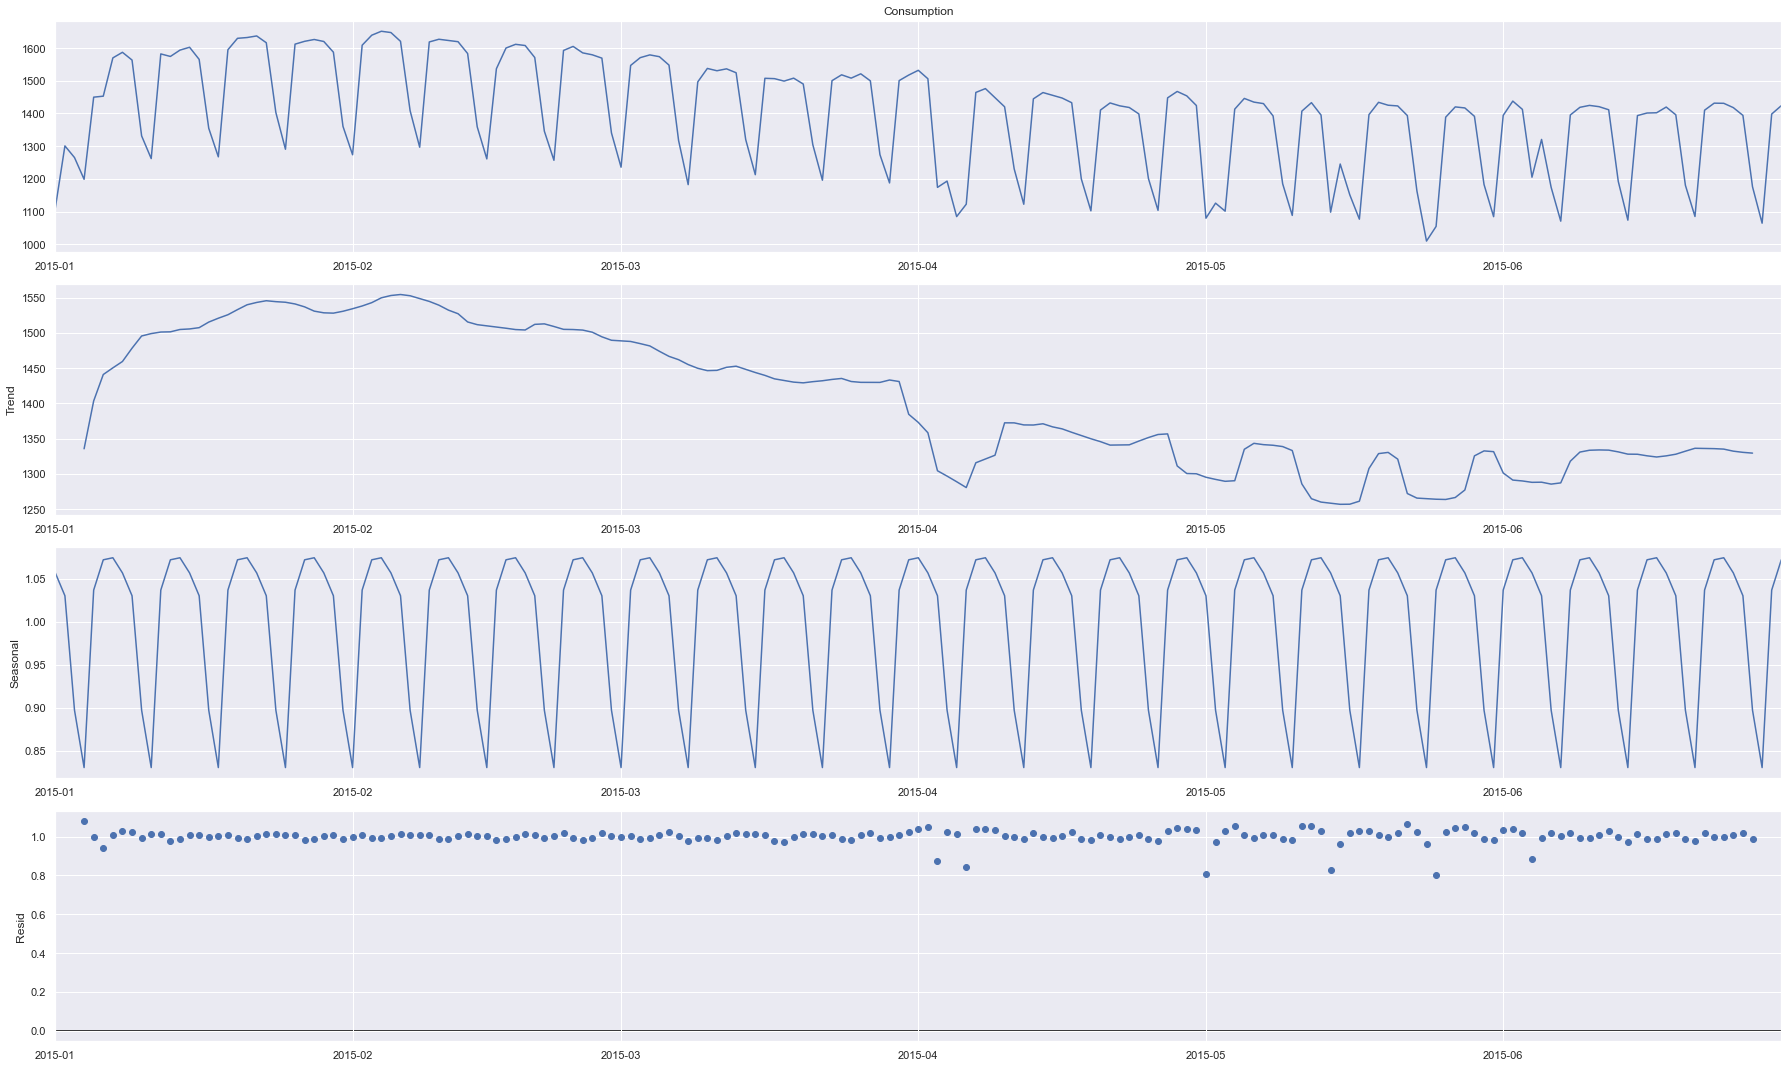

In [20]:
plot = decomposition.plot()#avoids repeated plots

Note how the residuals in this case has average $1$, while in the additive case it used to average to $0$.

### Comments on classical decomposition

While classical decomposition is still widely used, it is recommended only at the initial stage of the analysis, as there are now several much better methods. Some of the problems with classical decomposition are summarised below.

* The estimate of the trend-cycle is unavailable for the first few and last few observations. For example, if $\mu = 12$, there is no trend-cycle estimate for the first six or the last six observations. Consequently, there is also no estimate of the remainder component for the same time periods.

* The trend-cycle estimate tends to over-smooth rapid rises and falls in the data (as seen in the above example).

* Classical decomposition methods assume that the seasonal component repeats from year to year. For many series, this is a reasonable assumption, but for some longer series it is not. For example, electricity demand patterns have changed over time as air conditioning has become more widespread. Specifically, in many locations, the seasonal usage pattern from several decades ago had its maximum demand in winter (due to heating), while the current seasonal pattern has its maximum demand in summer (due to air conditioning). The classical decomposition methods are unable to capture these seasonal changes over time.

* Occasionally, the values of the time series in a small number of periods may be particularly unusual. For example, the monthly air passenger traffic may be affected by an industrial dispute, making the traffic during the dispute different from usual. The classical method is not robust to these kinds of unusual values.

---
### Exercise 2

Import and plot the time series [`alcohol_sales`](datasets/alcohol_sales.csv).

1. Find the series decomposition.
2. Plot the components and try to describe them
3. Analyse residual distribution and try to find out if they follow a normal, etc.

### Exercise 3

Import and plot the time series [`co2-ppm`]('https://pkgstore.datahub.io/core/co2-ppm-daily/co2-ppm-daily_csv/data/f2f91444294eec9f764430483fafc6be/co2-ppm-daily_csv.csv'). 

1. Try to plot the series and decompose it.
2. Find the distribution of the residual part. Does it follow a Gaussian curve?